In [86]:
#Importing Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB



In [87]:
file_path = r'C:\Users\HP\Downloads\final1.csv'
dataset = pd.read_csv(file_path)

In [88]:
#we identified some stopwords in urdu and removed them
custom_urdu_stopwords = set([    "اور", "سے", "کا", "کی", "ہے", "کو", "پر", "یہ", "میں", "جو", "وہ", "کہ", "ایک", "ہم", "تم", "آپ", "سب", "کچھ"])

def clean_text(text):
    text = ' '.join([word for word in text.split() if word not in custom_urdu_stopwords])  
    return text


dataset = dataset[['content', 'gold_label']].dropna()
dataset['content'] = dataset['content'].apply(clean_text)


In [89]:
print(dataset['content'].shape[0])

1441


In [90]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(dataset['content'], dataset['gold_label'], test_size=0.2, random_state=42)

In [91]:
class BagOfWords:
    def __init__(self):
        self.vocab = {}
        self.vocab_size = 0

    def fit(self, corpus):
        for sentence in corpus:
            words = self._tokenize(sentence)
            for word in words:
                if word not in self.vocab:
                    self.vocab[word] = self.vocab_size
                    self.vocab_size += 1

    def vectorize(self, sentence):
        vector = np.zeros(self.vocab_size)
        words = self._tokenize(sentence)
        for word in words:
            if word in self.vocab:
                index = self.vocab[word]
                vector[index] += 1
        return vector

    def _tokenize(self, sentence):
        return sentence.split()

bow = BagOfWords()
bow.fit(X_train_raw)

X_train = np.array([bow.vectorize(text) for text in X_train_raw])
X_test = np.array([bow.vectorize(text) for text in X_test_raw])


In [92]:
class NaiveBayes:
    def __init__(self):
        self.class_log_prior_ = None
        self.feature_log_prob_ = None
        self.classes_ = None
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        self.class_log_prior_ = np.zeros(n_classes)
        self.feature_log_prob_ = np.zeros((n_classes, n_features))

        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]
            n_c = X_c.shape[0]
            self.class_log_prior_[idx] = np.log(n_c / n_samples)

            word_count = X_c.sum(axis=0)
            total_word_count = word_count.sum()
            self.feature_log_prob_[idx] = np.log((word_count + 1) / (total_word_count + n_features))
    
    def predict(self, X):
        log_posterior = self._calculate_log_posterior(X)
        return self.classes_[np.argmax(log_posterior, axis=1)]
    
    def _calculate_log_posterior(self, X):
        log_posterior = X @ self.feature_log_prob_.T + self.class_log_prior_
        return log_posterior


In [93]:
naive_bayes = NaiveBayes()
naive_bayes.fit(X_train, np.array(y_train))


y_pred = naive_bayes.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\n")
print(X_train.shape[0],y_train.shape[0],X_test.shape[0],y_test.shape[0])

Accuracy: 97.92%
Precision: 97.89%
Recall: 97.88%
F1 Score: 97.88%

Confusion Matrix:
[[68  0  0  0  1]
 [ 0 60  0  0  0]
 [ 0  0 43  0  1]
 [ 0  0  0 57  1]
 [ 1  1  1  0 55]]


1152 1152 289 289


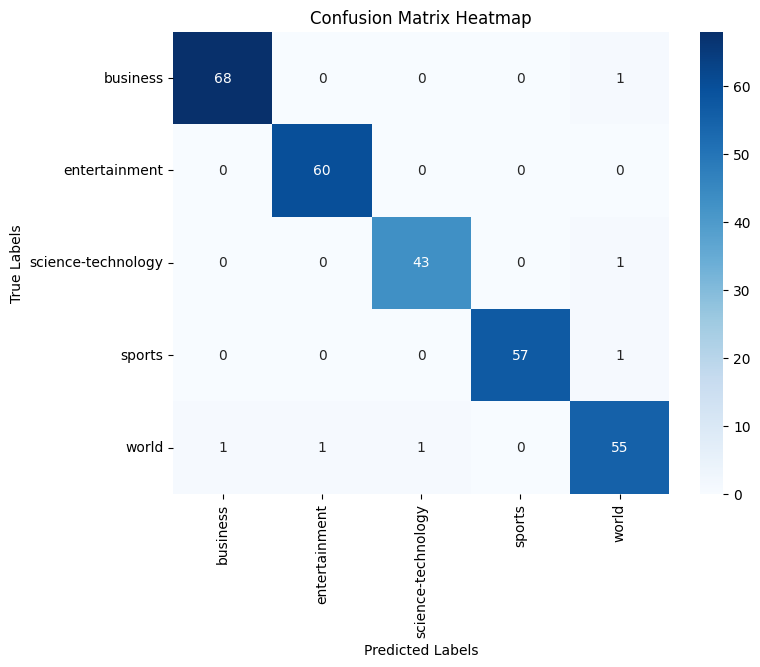

In [94]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [95]:
#testing for sklearn
X = dataset['content']  
y = dataset['gold_label']  
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train_raw)  
X_test = vectorizer.transform(X_test_raw)  
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 97.92%
